In [54]:
import os
import numpy as np

In [55]:
def load_conll(file_path):
    """
    Đọc file .conll và trả về list các câu và list các nhãn tương ứng.
    """
    sentences = []
    tags = []

    current_sent = []
    current_tags = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Gặp dòng trắng (hoặc hết file) nghĩa là kết thúc 1 câu
            if not line:
                if len(current_sent) > 0:
                    sentences.append(current_sent)
                    tags.append(current_tags)
                    current_sent = []
                    current_tags = []
            else:
                # Tách từ và nhãn (cách nhau bởi space)
                parts = line.split()
                # "Bác_sĩ O" -> len=2

                if len(parts) >= 2:
                    word = parts[0]
                    tag = parts[-1] # Lấy phần tử cuối cùng làm tag

                    current_sent.append(word)
                    current_tags.append(tag)

    # Thêm câu cuối cùng nếu file không kết thúc bằng dòng trắng
    if len(current_sent) > 0:
        sentences.append(current_sent)
        tags.append(current_tags)

    return sentences, tags

In [56]:
data_dir = "./dataset/PhoNER-COVID19/"

# Đường dẫn đến các file conll
train_file = os.path.join(data_dir, "train_word.conll")
dev_file   = os.path.join(data_dir, "dev_word.conll")
test_file  = os.path.join(data_dir, "test_word.conll")

# Load dữ liệu
train_sents, train_tags = load_conll(train_file)
dev_sents, dev_tags     = load_conll(dev_file)
test_sents, test_tags    = load_conll(test_file)

print(f"Số lượng câu train: {len(train_sents)}")
print(f"Câu train đầu tiên: {train_sents[0]}")
print(f"Số lượng unique nhãn train: {len(set(tag for tags in train_tags for tag in tags))}")

Số lượng câu train: 5027
Câu train đầu tiên: ['Đồng_thời', ',', 'bệnh_viện', 'tiếp_tục', 'thực_hiện', 'các', 'biện_pháp', 'phòng_chống', 'dịch_bệnh', 'COVID', '-', '19', 'theo', 'hướng_dẫn', 'của', 'Bộ', 'Y_tế', '.']
Số lượng unique nhãn train: 20


In [57]:
MAX_LEN = 126
NUM_CLASSES = 21

In [58]:
def create_vocab(sentences):
    """Tạo bộ từ điển từ danh sách các câu (list of lists)"""
    vocab_set = set()
    for sent in sentences:
        vocab_set.update(sent)
    return sorted(list(vocab_set))

def create_mappings(vocab_list, all_tags_list):
    """Tạo mapping từ chữ/nhãn sang số"""
    # word2idx: 0 cho Padding, 1 cho Unknown
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    for idx, word in enumerate(vocab_list, start=2):
        word2idx[word] = idx

    # tag2idx: Chỉ map các nhãn thực tế
    unique_tags = sorted(list(set(tag for tags in all_tags_list for tag in tags)))
    tag2idx = {tag: idx for idx, tag in enumerate(unique_tags)}

    return word2idx, tag2idx

In [59]:
vocab_list = create_vocab(train_sents)
word2idx, tag2idx = create_mappings(vocab_list, train_tags)

print(f"Kích thước tập từ vựng (Vocab size): {len(word2idx)}")
print(f"Danh sách nhãn và ID tương ứng:\n{tag2idx}")

Kích thước tập từ vựng (Vocab size): 5243
Danh sách nhãn và ID tương ứng:
{'B-AGE': 0, 'B-DATE': 1, 'B-GENDER': 2, 'B-JOB': 3, 'B-LOCATION': 4, 'B-NAME': 5, 'B-ORGANIZATION': 6, 'B-PATIENT_ID': 7, 'B-SYMPTOM_AND_DISEASE': 8, 'B-TRANSPORTATION': 9, 'I-AGE': 10, 'I-DATE': 11, 'I-JOB': 12, 'I-LOCATION': 13, 'I-NAME': 14, 'I-ORGANIZATION': 15, 'I-PATIENT_ID': 16, 'I-SYMPTOM_AND_DISEASE': 17, 'I-TRANSPORTATION': 18, 'O': 19}


In [60]:
def encode_and_pad(data_sents, data_tags, word2idx, tag2idx, max_len):
    """Chuyển câu và nhãn thành dãy số và padding"""
    encoded_sents = []
    encoded_tags = []

    for sent, tags in zip(data_sents, data_tags):
        # 1. Encode Sentence
        sent_seq = [word2idx.get(word, word2idx['<UNK>']) for word in sent]

        # 2. Encode Tags
        tag_seq = [tag2idx.get(tag) for tag in tags]

        # 3. Padding/Truncating
        if len(sent_seq) < max_len:
            # Padding: Thêm 0 cho câu, thêm -100 cho nhãn
            sent_seq = sent_seq + [word2idx['<PAD>']] * (max_len - len(sent_seq))
            tag_seq = tag_seq + [-100] * (max_len - len(tag_seq))
        else:
            # Truncating: Cắt bớt nếu dài quá max_len
            sent_seq = sent_seq[:max_len]
            tag_seq = tag_seq[:max_len]

        encoded_sents.append(sent_seq)
        encoded_tags.append(tag_seq)

    return np.array(encoded_sents), np.array(encoded_tags)

In [61]:
# Thực thi mã hóa cho cả 3 tập
train_ids, train_tag_ids = encode_and_pad(train_sents, train_tags, word2idx, tag2idx, MAX_LEN)
dev_ids, dev_tag_ids = encode_and_pad(dev_sents, dev_tags, word2idx, tag2idx, MAX_LEN)
test_ids, test_tag_ids = encode_and_pad(test_sents, test_tags, word2idx, tag2idx, MAX_LEN)

print(f"Shape tập train: {train_ids.shape}")
print(f"Shape nhãn train: {train_tag_ids.shape}")
print("Câu đầu tiên:", train_ids[0][:20])
print("Câu đầu tiên:", train_tag_ids[0][:20])

Shape tập train: (5027, 126)
Shape nhãn train: (5027, 126)
Câu đầu tiên: [5019   10 2783 4457 4421 2999 2687 4037 3186 1283   11  265 4296 3383
 3104 1267 2644   12    0    0]
Câu đầu tiên: [  19   19   19   19   19   19   19   19   19   19   19   19   19   19
   19    6   15   19 -100 -100]


In [62]:
print(train_ids.dtype)
print(type(train_ids))

int64
<class 'numpy.ndarray'>


In [63]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Chuyển đổi Numpy sang Tensor
# Lưu ý: Input là LongTensor (số nguyên) vì nó là index
train_data = TensorDataset(torch.from_numpy(train_ids), torch.from_numpy(train_tag_ids))
dev_data = TensorDataset(torch.from_numpy(dev_ids), torch.from_numpy(dev_tag_ids))
test_data = TensorDataset(torch.from_numpy(test_ids), torch.from_numpy(test_tag_ids))

# Thiết lập Batch Size
BATCH_SIZE = 32

# Tạo DataLoader
# shuffle=True cho tập train để mô hình học tốt hơn
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
dev_loader = DataLoader(dev_data, shuffle=False, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE)

print(f"Số lượng batch trong tập train: {len(train_loader)}")

Số lượng batch trong tập train: 158


In [64]:
import torch.nn as nn

class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout=0.5):
        super(BiLSTM_NER, self).__init__()

        # Embedding Layer
        # padding_idx=0: Vector tại index 0 sẽ luôn là vector 0, không được train
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            bidirectional=True, # Bi-directional
                            batch_first=True,   # Input dạng [batch, seq_len, feature]
                            dropout=dropout)

        # Fully Connected Layer (Classifier)
        # Input của FC là hidden_size * 2 (do 2 chiều xuôi/ngược)
        self.fc = nn.Linear(hidden_size * 2, n_classes) # Không softmax, vì dùng CrossEntropyLoss

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: [batch_size, seq_len]

        # Pass qua Embedding
        embedded = self.embedding(x)
        embedded = self.dropout(embedded) # sinh ra tensor [batch, seq_len, embedding_dim]

        # Pass qua LSTM
        # outputs shape: [batch_size, seq_len, hidden_size * 2]
        outputs, hidden = self.lstm(embedded)
        outputs = self.dropout(outputs)

        # Pass qua FC để ra xác suất cho từng class
        # predictions shape: [batch_size, seq_len, n_classes]
        predictions = self.fc(outputs)

        return predictions

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BiLSTM_NER(vocab_size=len(word2idx),
                   embedding_dim=100,  # Thường chọn 100 hoặc 300
                   hidden_size=256,    # Theo đề bài
                   n_layers=5,         # Theo đề bài
                   n_classes=NUM_CLASSES,
                   dropout=0.3).to(device)

print(model)

BiLSTM_NER(
  (embedding): Embedding(5243, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=5, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=21, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [67]:
import torch.optim as optim

# Định nghĩa Loss Function
# ignore_index=-100: Bỏ qua các nhãn padding khi tính loss
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Định nghĩa Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel architecture:\n{model}")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Model architecture:
BiLSTM_NER(
  (embedding): Embedding(5243, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=5, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=21, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Total parameters: 7,576,097


In [68]:
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train() # Chuyển model sang chế độ train (bật dropout)
    epoch_loss = 0

    for batch_sents, batch_tags in tqdm(dataloader, desc="Training"):
        # Chuyển data lên GPU
        batch_sents = batch_sents.to(device)
        batch_tags = batch_tags.to(device)

        # 1. Xóa gradient cũ
        optimizer.zero_grad()

        # 2. Forward pass
        # predictions shape: [batch_size, seq_len, n_classes]
        predictions = model(batch_sents)

        # 3. Tính Loss
        # PyTorch CrossEntropy yêu cầu:
        # - Input: [Batch_size * Seq_len, Num_classes] (2D)
        # - Target: [Batch_size * Seq_len] (1D)
        predictions = predictions.view(-1, predictions.shape[-1])
        batch_tags = batch_tags.view(-1)

        loss = criterion(predictions, batch_tags)

        # 4. Backward pass
        loss.backward()

        # 5. Update weights
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

# Chạy thử 1 epoch để xem code có lỗi không trước khi train full
print("Đang chạy thử 1 epoch...")
train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
print(f"Train Loss: {train_loss:.4f}")

Đang chạy thử 1 epoch...


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.43it/s]

Train Loss: 1.2997


In [69]:
from seqeval.metrics import classification_report, f1_score

# 1. Tạo dict ngược để dịch số về nhãn (0 -> B-ORG)
idx2tag = {v: k for k, v in tag2idx.items()}

def evaluate(model, dataloader, criterion, device):
    model.eval() # Quan trọng: Tắt dropout
    epoch_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad(): # Tắt tính gradient để tiết kiệm RAM
        for batch_sents, batch_tags in dataloader:
            batch_sents = batch_sents.to(device)
            batch_tags = batch_tags.to(device)

            # Forward pass
            predictions = model(batch_sents)

            # --- TÍNH VAL LOSS ---
            # Reshape giống lúc train
            predictions_flat = predictions.view(-1, predictions.shape[-1])
            batch_tags_flat = batch_tags.view(-1)
            loss = criterion(predictions_flat, batch_tags_flat)
            epoch_loss += loss.item()

            # Lấy nhãn có xác suất cao nhất (argmax)
            # predictions shape: [batch, seq_len, n_classes] -> [batch, seq_len]
            preds = torch.argmax(predictions, dim=2)

            # Chuyển Tensor về List python để xử lý
            preds = preds.detach().cpu().numpy()
            targets = batch_tags.detach().cpu().numpy()

            # Lặp qua từng câu trong batch
            for p_sent, t_sent in zip(preds, targets):
                sent_true = []
                sent_pred = []

                # Lặp qua từng từ trong câu
                for p, t in zip(p_sent, t_sent):
                    # Quan trọng: Chỉ lấy những nhãn KHÔNG phải là padding (-100)
                    if t != -100:
                        sent_true.append(idx2tag[t])
                        sent_pred.append(idx2tag[p])

                # Lưu lại kết quả của câu đó
                y_true.append(sent_true)
                y_pred.append(sent_pred)

    return epoch_loss / len(dataloader), y_true, y_pred

In [83]:
import time
import torch
from seqeval.metrics import f1_score

N_EPOCHS = 50

# Biến lưu F1 tốt nhất để checkpoint
best_valid_f1 = float('-inf')
history = {'train_loss': [], 'valid_loss': [], 'valid_f1': []}

print(f"Bắt đầu huấn luyện {N_EPOCHS} epochs trên thiết bị: {device}")
print("-" * 80)

for epoch in range(N_EPOCHS):
    start_time = time.time()

    # 1. Huấn luyện (Train)
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    # 2. Đánh giá trên tập Dev (Validation)
    # Lưu ý: Hàm evaluate đã định nghĩa ở bước trước, trả về list các nhãn thực và dự đoán
    val_loss, true_labels, pred_labels = evaluate(model, dev_loader, criterion, device)
    valid_f1 = f1_score(true_labels, pred_labels)

    # 3. Lưu lịch sử
    history['train_loss'].append(train_loss)
    history['valid_f1'].append(valid_f1)
    history['valid_loss'].append(val_loss)
    # history['train_f1'].append(train_f1)

    # 4. Lưu model tốt nhất (Checkpoint)
    save_msg = ""
    if valid_f1 > best_valid_f1:
        best_valid_f1 = valid_f1
        torch.save(model.state_dict(), 'bilstm_phoner_word.pth')
        save_msg = "--> Đã lưu model"

    # In kết quả epoch
    end_time = time.time()
    mins, secs = divmod(end_time - start_time, 60)

    print(f'Epoch: {epoch+1:02} | Time: {int(mins)}m {int(secs)}s | '
          f'Train Loss: {train_loss:.4f} | Val F1: {valid_f1:.4f} {save_msg}')

Bắt đầu huấn luyện 50 epochs trên thiết bị: cuda
--------------------------------------------------------------------------------


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.43it/s]


Epoch: 01 | Time: 0m 15s | Train Loss: 0.0185 | Val F1: 0.8909 --> Đã lưu model


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.77it/s]


Epoch: 02 | Time: 0m 15s | Train Loss: 0.0184 | Val F1: 0.8914 --> Đã lưu model


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.74it/s]


Epoch: 03 | Time: 0m 15s | Train Loss: 0.0180 | Val F1: 0.8921 --> Đã lưu model


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.27it/s]


Epoch: 04 | Time: 0m 14s | Train Loss: 0.0172 | Val F1: 0.8858 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.13it/s]


Epoch: 05 | Time: 0m 15s | Train Loss: 0.0178 | Val F1: 0.8908 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.80it/s]


Epoch: 06 | Time: 0m 15s | Train Loss: 0.0160 | Val F1: 0.8883 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.05it/s]


Epoch: 07 | Time: 0m 14s | Train Loss: 0.0152 | Val F1: 0.8906 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.12it/s]


Epoch: 08 | Time: 0m 14s | Train Loss: 0.0163 | Val F1: 0.8879 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.04it/s]


Epoch: 09 | Time: 0m 15s | Train Loss: 0.0153 | Val F1: 0.8917 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.22it/s]


Epoch: 10 | Time: 0m 14s | Train Loss: 0.0166 | Val F1: 0.8886 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.94it/s]


Epoch: 11 | Time: 0m 15s | Train Loss: 0.0161 | Val F1: 0.8925 --> Đã lưu model


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.21it/s]


Epoch: 12 | Time: 0m 14s | Train Loss: 0.0151 | Val F1: 0.8911 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.31it/s]


Epoch: 13 | Time: 0m 16s | Train Loss: 0.0141 | Val F1: 0.8886 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:14<00:00, 10.78it/s]


Epoch: 14 | Time: 0m 17s | Train Loss: 0.0139 | Val F1: 0.8938 --> Đã lưu model


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:14<00:00, 10.72it/s]


Epoch: 15 | Time: 0m 16s | Train Loss: 0.0158 | Val F1: 0.8872 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:14<00:00, 11.04it/s]


Epoch: 16 | Time: 0m 16s | Train Loss: 0.0180 | Val F1: 0.8871 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.15it/s]


Epoch: 17 | Time: 0m 15s | Train Loss: 0.0145 | Val F1: 0.8904 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.87it/s]


Epoch: 18 | Time: 0m 15s | Train Loss: 0.0123 | Val F1: 0.8917 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.55it/s]


Epoch: 19 | Time: 0m 15s | Train Loss: 0.0123 | Val F1: 0.8892 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.71it/s]


Epoch: 20 | Time: 0m 15s | Train Loss: 0.0119 | Val F1: 0.8907 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.33it/s]


Epoch: 21 | Time: 0m 16s | Train Loss: 0.0140 | Val F1: 0.8913 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:14<00:00, 11.23it/s]


Epoch: 22 | Time: 0m 16s | Train Loss: 0.0126 | Val F1: 0.8872 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.48it/s]


Epoch: 23 | Time: 0m 15s | Train Loss: 0.0139 | Val F1: 0.8885 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.12it/s]


Epoch: 24 | Time: 0m 14s | Train Loss: 0.0120 | Val F1: 0.8877 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.03it/s]


Epoch: 25 | Time: 0m 15s | Train Loss: 0.0115 | Val F1: 0.8919 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.31it/s]


Epoch: 26 | Time: 0m 14s | Train Loss: 0.0104 | Val F1: 0.8941 --> Đã lưu model


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.08it/s]


Epoch: 27 | Time: 0m 15s | Train Loss: 0.0105 | Val F1: 0.8839 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.94it/s]


Epoch: 28 | Time: 0m 15s | Train Loss: 0.0099 | Val F1: 0.8936 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.12it/s]


Epoch: 29 | Time: 0m 14s | Train Loss: 0.0107 | Val F1: 0.8890 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.23it/s]


Epoch: 30 | Time: 0m 14s | Train Loss: 0.0105 | Val F1: 0.8902 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.19it/s]


Epoch: 31 | Time: 0m 14s | Train Loss: 0.0113 | Val F1: 0.8868 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.80it/s]


Epoch: 32 | Time: 0m 15s | Train Loss: 0.0107 | Val F1: 0.8872 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.14it/s]


Epoch: 33 | Time: 0m 14s | Train Loss: 0.0111 | Val F1: 0.8918 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.06it/s]


Epoch: 34 | Time: 0m 15s | Train Loss: 0.0102 | Val F1: 0.8861 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.17it/s]


Epoch: 35 | Time: 0m 14s | Train Loss: 0.0092 | Val F1: 0.8896 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.04it/s]


Epoch: 36 | Time: 0m 15s | Train Loss: 0.0105 | Val F1: 0.8913 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.15it/s]


Epoch: 37 | Time: 0m 14s | Train Loss: 0.0096 | Val F1: 0.8875 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.08it/s]


Epoch: 38 | Time: 0m 14s | Train Loss: 0.0091 | Val F1: 0.8925 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.32it/s]


Epoch: 39 | Time: 0m 14s | Train Loss: 0.0096 | Val F1: 0.8927 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.21it/s]


Epoch: 40 | Time: 0m 14s | Train Loss: 0.0083 | Val F1: 0.8933 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.86it/s]


Epoch: 41 | Time: 0m 15s | Train Loss: 0.0097 | Val F1: 0.8933 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 11.98it/s]


Epoch: 42 | Time: 0m 15s | Train Loss: 0.0085 | Val F1: 0.8909 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:12<00:00, 12.19it/s]


Epoch: 43 | Time: 0m 15s | Train Loss: 0.0078 | Val F1: 0.8984 --> Đã lưu model


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:16<00:00,  9.44it/s]


Epoch: 44 | Time: 0m 18s | Train Loss: 0.0084 | Val F1: 0.8936 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:16<00:00,  9.61it/s]


Epoch: 45 | Time: 0m 18s | Train Loss: 0.0083 | Val F1: 0.8948 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:18<00:00,  8.74it/s]


Epoch: 46 | Time: 0m 20s | Train Loss: 0.0086 | Val F1: 0.8920 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:17<00:00,  8.97it/s]


Epoch: 47 | Time: 0m 19s | Train Loss: 0.0076 | Val F1: 0.8930 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:14<00:00, 11.15it/s]


Epoch: 48 | Time: 0m 16s | Train Loss: 0.0082 | Val F1: 0.8949 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.00it/s]


Epoch: 49 | Time: 0m 15s | Train Loss: 0.0076 | Val F1: 0.8913 


Training: 100%|██████████████████████████████████████████████████████████████████████| 158/158 [00:13<00:00, 12.05it/s]


Epoch: 50 | Time: 0m 15s | Train Loss: 0.0077 | Val F1: 0.8872 


In [84]:
from seqeval.metrics import classification_report

# Load lại trọng số của model tốt nhất (Best Checkpoint)
model.load_state_dict(torch.load('bilstm_phoner_word.pth', map_location=device))

# Chạy đánh giá trên tập Test
_, test_true_labels, test_pred_labels = evaluate(model, test_loader, criterion, device)

# In báo cáo chi tiết
print("\n" + "="*30)
print("KẾT QUẢ ĐÁNH GIÁ (TEST SET)")
print("="*30)
print(classification_report(test_true_labels, test_pred_labels, digits=4))


KẾT QUẢ ĐÁNH GIÁ (TEST SET)
                     precision    recall  f1-score   support

                AGE     0.9466    0.9449    0.9457       581
               DATE     0.9459    0.9625    0.9541      1652
             GENDER     0.9323    0.9262    0.9293       461
                JOB     0.6981    0.4277    0.5305       173
           LOCATION     0.8917    0.9004    0.8960      4437
               NAME     0.7900    0.5440    0.6443       318
       ORGANIZATION     0.8204    0.7821    0.8008       771
         PATIENT_ID     0.9267    0.9595    0.9428      2002
SYMPTOM_AND_DISEASE     0.8034    0.7843    0.7938      1136
     TRANSPORTATION     0.8730    0.8549    0.8639       193

          micro avg     0.8932    0.8860    0.8896     11724
          macro avg     0.8628    0.8087    0.8301     11724
       weighted avg     0.8905    0.8860    0.8871     11724



In [85]:
from collections import Counter

all_tags = [tag for tags in train_tags for tag in tags]
tag_counts = Counter(all_tags)

print(f"{'Tag':<30} {'Count'}")
print("-" * 40)
for tag, count in tag_counts.most_common():
    print(f"{tag:<30} {count}")

Tag                            Count
----------------------------------------
O                              104750
B-LOCATION                     5398
I-LOCATION                     5242
B-PATIENT_ID                   3240
B-DATE                         2549
I-ORGANIZATION                 2545
I-DATE                         2500
I-SYMPTOM_AND_DISEASE          1552
B-SYMPTOM_AND_DISEASE          1439
B-ORGANIZATION                 1137
B-AGE                          682
B-GENDER                       542
B-NAME                         349
B-TRANSPORTATION               226
B-JOB                          205
I-TRANSPORTATION               67
I-JOB                          62
I-NAME                         13
I-PATIENT_ID                   11
I-AGE                          2


In [86]:
import pandas as pd
from collections import defaultdict

def analyze_diversity(sentences, tags, target_list=['JOB', 'NAME', 'TRANSPORTATION']):
    # Lưu danh sách các từ vựng thu được cho mỗi nhãn
    entities = defaultdict(list)

    for sent, sent_tags in zip(sentences, tags):
        curr_words, curr_tag = [], None

        for word, tag in zip(sent, sent_tags):
            # Bắt đầu thực thể mới (B-)
            if tag.startswith('B-'):
                if curr_tag in target_list: entities[curr_tag].append(" ".join(curr_words))
                curr_words, curr_tag = [word], tag[2:] # Lấy tên nhãn bỏ tiền tố B-
            # Nối tiếp thực thể cũ (I-)
            elif tag.startswith('I-') and curr_tag == tag[2:]:
                curr_words.append(word)
            # Gặp O hoặc nhãn khác -> Kết thúc thực thể hiện tại
            else:
                if curr_tag in target_list: entities[curr_tag].append(" ".join(curr_words))
                curr_words, curr_tag = [], None

        # Xử lý thực thể nằm cuối câu
        if curr_tag in target_list: entities[curr_tag].append(" ".join(curr_words))

    # In bảng thống kê
    print(f"{'TAG':<15} | {'TOTAL':<6} | {'UNIQUE':<6} | {'RATIO':<6} | {'TOP 3 EXAMPLES'}")
    print("-" * 100)

    for tag in target_list:
        vals = entities[tag]
        total, unique = len(vals), len(set(vals))
        # Ratio = 1 nghĩa là mỗi từ chỉ xuất hiện đúng 1 lần (siêu đa dạng/khó học)
        # Ratio gần 0 nghĩa là lặp lại nhiều (dễ học)
        ratio = unique / total if total > 0 else 0

        # Lấy top 10 từ xuất hiện nhiều nhất
        top10 = pd.Series(vals).value_counts().head(10).index.tolist()
        print(f"{tag:<15} | {total:<6} | {unique:<6} | {ratio:<6.2f} | {top10}")

# --- GỌI HÀM ---
analyze_diversity(train_sents, train_tags)

TAG             | TOTAL  | UNIQUE | RATIO  | TOP 3 EXAMPLES
----------------------------------------------------------------------------------------------------
JOB             | 205    | 50     | 0.24   | ['phi_công', 'điều_dưỡng', 'du_học_sinh', 'lái_xe', 'doanh_nhân', 'tiếp_viên', 'công_nhân', 'nhân_viên y_tế', 'thầy_giáo', 'buôn_bán']
NAME            | 349    | 112    | 0.32   | ['T.', 'N.H.N.', 'Nhung', 'Nguyễn_Hồng_Nhung', 'H.', 'N.', 'C.', 'B', 'D.Đ.P.', 'A']
TRANSPORTATION  | 226    | 69     | 0.31   | ['VN54', 'VN0054', 'VN 0054', 'VN0062', 'SU 290', 'VN6', 'VN5062', 'VN50', 'VN0050', 'VN 54']


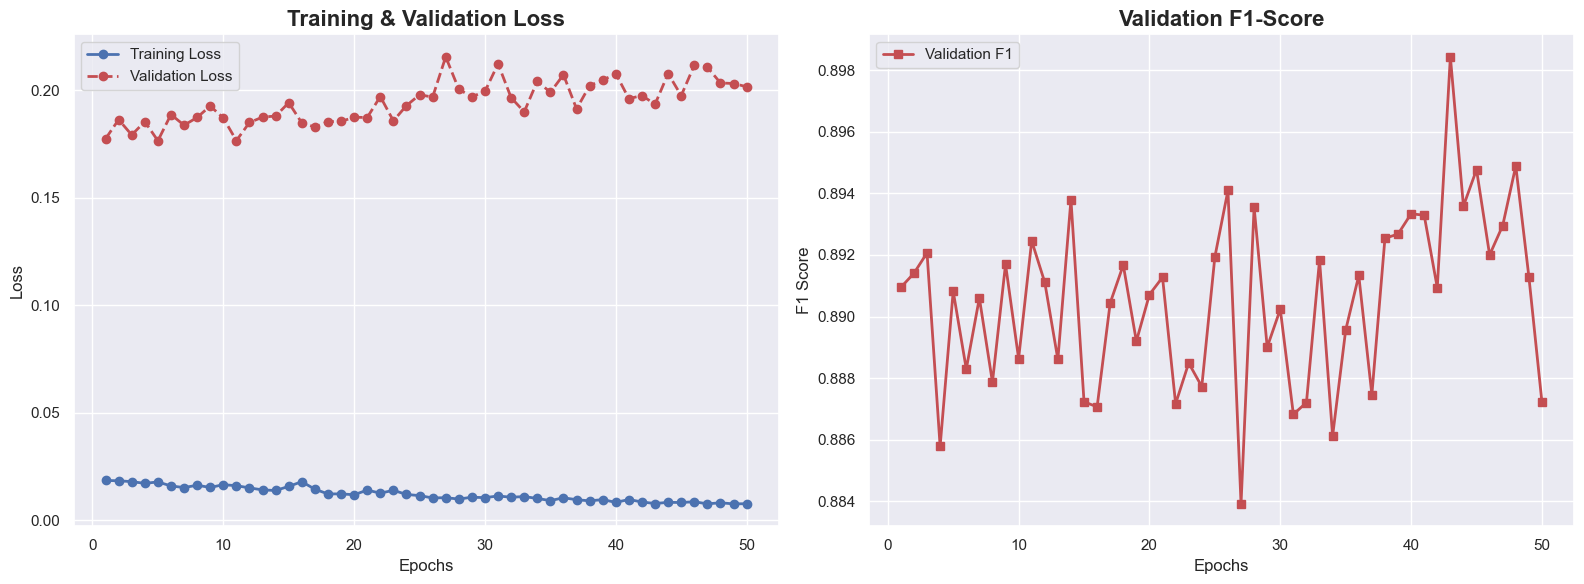

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sử dụng style seaborn
sns.set(style='darkgrid')

def plot_training_history(history):
    """
    history: dictionary chứa các key: 'train_loss', 'valid_loss', 'train_f1', 'valid_f1'
    """

    # Tạo khung hình vẽ gồm 2 biểu đồ con
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Lấy dữ liệu epochs
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Biểu đồ 1: Loss (Train vs Valid) ---
    # Vẽ Train Loss
    ax1.plot(epochs, history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
    # Vẽ Valid Loss (nếu có trong history)
    if 'valid_loss' in history:
        ax1.plot(epochs, history['valid_loss'], 'r--o', label='Validation Loss', linewidth=2)

    ax1.set_title('Training & Validation Loss', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(loc='best')

    # --- Biểu đồ 2: F1-Score (Train vs Valid) ---
    # Vẽ Valid F1 (Quan trọng nhất)
    if 'valid_f1' in history:
        ax1_line = ax2.plot(epochs, history['valid_f1'], 'r-s', label='Validation F1', linewidth=2)

    # Vẽ Train F1 (để so sánh xem có học tủ không)
    if 'train_f1' in history:
        ax2.plot(epochs, history['train_f1'], 'b--s', label='Training F1', linewidth=2, alpha=0.6)

    ax2.set_title('Validation F1-Score', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Gọi hàm (đảm bảo biến history của bạn đã lưu đủ các thông số trên)
plot_training_history(history)

In [88]:
# ===============================
# TEST 1 CÂU VỚI MODEL ĐÃ TRAIN
# ===============================

import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM_NER(
    vocab_size=len(word2idx),
    embed_dim=100,
    hidden_dim=256,
    num_labels=len(label2idx)
).to(device)

model.load_state_dict(
    torch.load("bilstm_phoner_word.pth", map_location=device)
)
model.eval()

print("✅ Đã load model thành công")

print("Đã load model thành công")

# 2. Hàm test 1 câu
def predict_sentence(sentence, model, word2idx, idx2tag, max_len=126):
    """
    sentence: list các token (word-level, ví dụ: ['Bác_sĩ', 'Nguyễn_Trung_Nguyên', ...])
    """

    # Encode sentence
    encoded = [word2idx.get(w, word2idx['<UNK>']) for w in sentence]

    # Padding
    if len(encoded) < max_len:
        encoded += [word2idx['<PAD>']] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]

    # Convert sang tensor
    input_tensor = torch.tensor(encoded).unsqueeze(0).to(device)
    # shape: [1, seq_len]

    with torch.no_grad():
        outputs = model(input_tensor)
        preds = torch.argmax(outputs, dim=2).squeeze(0).cpu().numpy()

    # Decode nhãn
    result = []
    for word, tag_id in zip(sentence, preds[:len(sentence)]):
        result.append((word, idx2tag[tag_id]))

    return result

# 3. Test thử 1 câu
test_sentence = [
    "Bác_sĩ", "Trần_Thanh_Linh", ",", "từ", "Bệnh_viện", "Chợ_Rẫy", "chi_viện", "phụ_trách", "đơn_nguyên", "hồi_sức", "tích_cực", ",", "cho", "biết", "\"", "bệnh_nhân", "416", "\"", "vẫn", "đang", "duy_trì", "ECMO", ",", "thở", "máy", ",", "hiện", "xơ", "phổi", "rất", "nhiều", "."
]

predictions = predict_sentence(
    test_sentence,
    model,
    word2idx,
    idx2tag,
    MAX_LEN
)

# 4. In kết quả
print("\nKẾT QUẢ NHẬN DIỆN THỰC THỂ:")
for word, tag in predictions:
    print(f"{word:<20} → {tag}")


NameError: name 'label2idx' is not defined